## Fouled-off balls
What kinds of pitches are fouled off?

How do fouled-off pitches differ from called/swinging strikes, or other pitch outcomes?

Is it possible to discern what types of pitches might get fouled off?

Features that might matter: ball/strike count, pitch type, pitch location, pitch velocity, etc.

In [26]:
# Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [2]:
# PITCHfx data from 2016 Jun 1–3, parsed using the `pfx_parser_csv.py` script
data = pd.read_csv('edited_pitch_table.csv')

In [ ]:
data.head()     # To see what the data looks like

In [ ]:
list(data)     # Returns all column headers

In [ ]:
data.shape
# 64 features
# 12,134 samples (pitches) in this three day period

In [ ]:
#Split dataset into fouls and not-fouls
thefouls = data[data['pitch_res'] == 'F']
notfouls = data[data['pitch_res'] != 'F']
print('Fouls: ', thefouls.shape, 'Not Fouls: ', notfouls.shape)
# 2050 pitches were fouled off, 10,084 were not fouled off, unbalanced dataset.

Possible approaches:
1. Focus on fouled-off pitches, do K-means clustering do identify types of situations that lead to fouled-off pitches
2. Try to classify pitches as fouled or not-fouled, then investigate feature importance

I like the second approach to start with, maybe the first to follow-up

### Encoding the categorical variables

Several features are categorical, so they need to be encoded as 0/1s for each possible value

In [ ]:
# Which features are categorical?
X.dtypes
# Pitcher hand, batter hand, pitch sequence, pitch type, pitch type sequence

In [3]:
# Use pd.get_dummies() to encode these categorical variables
catcols = ['pit_hand_cd', 'bat_hand_cd', 'pitch_type']
hots = pd.get_dummies(data, columns=catcols, prefix = catcols)
#hots.head()
# Seems to work!

In [4]:
# Some rows have missing values, so drop them (not sure exactly where/what they are right now)
hots = hots.dropna()
hots.shape    # 20 samples dropped, due to the encoding, not sure why?

(12114, 78)

In [5]:
# Split data into X and y
'''We can look at all pitch outcomes first, then later focus on just fouls'''
y = hots['pitch_res']
# X needs to exclude old encoded columns, but also stuff like the gameID, teamIDs, etc...
dropcols = [
    'retro_game_id',
    'year',
    'st_fl',
    'regseason_fl',
    'playoffs_fl',
    'game_type',
    'game_type_des',
    'game_id',
    'home_team_id',
    'home_team_lg',
    'away_team_id',
    'away_team_lg',
    'interleague_fl',
    'park_name',
    'park_lock',
    'pitch_seq',      # Too difficult to encode, unfortunately...
    'pa_terminal_fl',
    'pa_event_cd',
    'pitch_res',
    'pitch_des',
    'pitch_id',
    'pitch_type_seq',    # Too difficult to encode, unfortunately...
    'sv_id',
    'x', 'y',     # Older, less useful PitchFX features, now replaced by 'px' and 'pz'
    'y0'          # Distance between the pitcher's release point and home plate, held constant by definition in the PitchFX data
]
X = hots.drop(dropcols, axis=1)
print('X: ', X.shape, 'y: ', y.shape)

X:  (12114, 52) y:  (12114,)


In [11]:
# Let's focus on pitches that are fouled-off, vs. all other pitches and their outcomes
# Use pd.get_dummies() again to easily draw out the fouled-off pitches
possres = list(set(y))
outcomes = pd.get_dummies(y, columns=possres)
fouls = outcomes['F']

In [12]:
'''IMPORTANT: Create sample weights to rebalance the data!'''
numnotfoul = len(fouls[fouls == 0])
numfoul = len(fouls[fouls == 1])
coefweight = numnotfoul / numfoul
print(coefweight)   # ~4.92x more not-fouls than fouls (will differ slightly with each train/test split)
sampweight = fouls.replace(0, coefweight)

4.917928676111383


In [13]:
# Train/test split with fouls this time instead of full y
X_train, X_test, y_train, y_test, samp_train, samp_test = train_test_split(X, fouls, sampweight, test_size=0.33, random_state=42)

In [14]:
# Random Forest Classification on foul T/F
foulforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
foulforest.fit(X_train, y_train, sample_weight = samp_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [15]:
# Need to include sample weights when assessing accuracy now
foulforest.score(X_test, y_test, sample_weight=samp_test.values)
# accuracy of 0.95, pretty good!

0.94823952218953877

In [30]:
# Plot an ROC Curve, to visualize the accuracy
# Generate predictions from the validation set's features
preds = foulforest.predict_proba(X_test)[:,1]
# Calculate the false positive and true positive rates, comparing the above predictions to the true values
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
# Calculate the AUC (area under the curve) score
auc = metrics.auc(fpr,tpr)
print('AUC: ', auc)

AUC:  0.709684141389


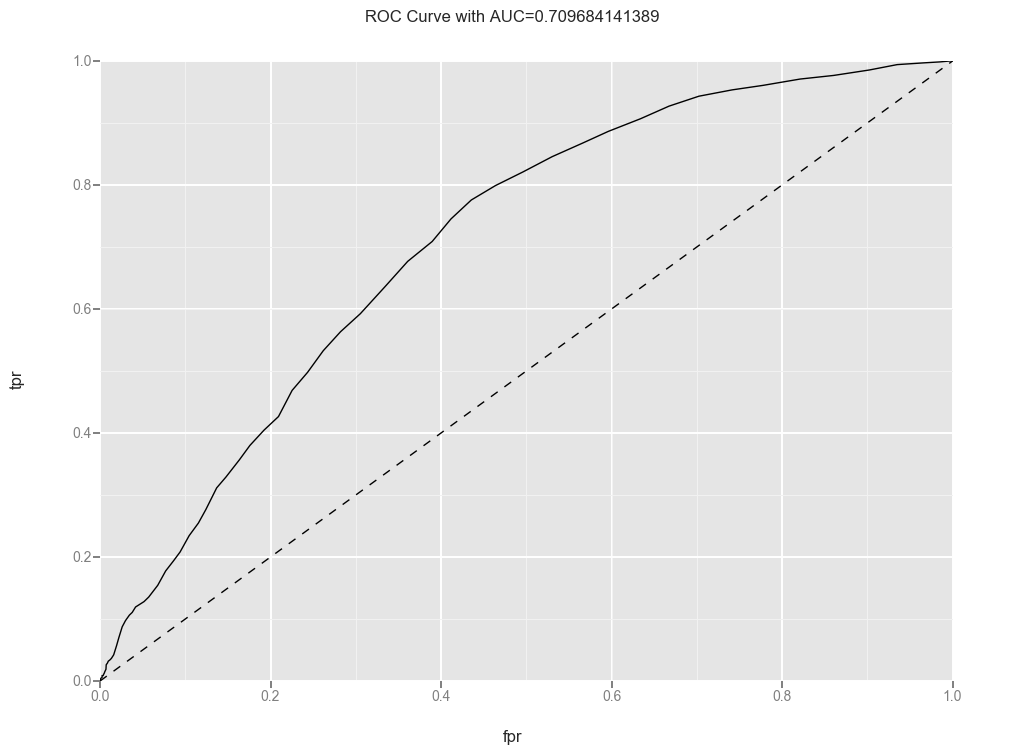

<ggplot: (-9223372036564056986)>

In [28]:
# ROC Curve Plotting
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle('ROC Curve with AUC=%s' % str(auc))

The bowed shape of the ROC curve shows that this model is pretty good at predicting which pitches will be fouled off! The AUC score of 0.71 is quite good for a problem such as this.

So what features are important for determining whether a pitch is fouled off or not?

In [16]:
# Feature importances, if interested
colsX = pd.Series(X_test.columns.values)
imps = pd.concat([colsX, pd.Series(foulforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
19,19,pz,0.042262
18,18,px,0.040106
26,26,ay,0.039687
21,21,z0,0.039035
31,31,type_conf,0.037413
17,17,pfx_z,0.037287
22,22,vx0,0.036825
24,24,vz0,0.036011
34,34,spin_rate,0.035719
20,20,x0,0.035428


## Random forest classification: foul T/F

The model seems pretty accurate as classifying pitches as fouls or not-fouls!

However, the feature importance is not terribly informative. Location seems to matter to a small degree (px/pz).

I'm not clear how the 'ay' feature (acceleration from the pitcher's mound to home plate) substantively differs from velocity (vy0), but apparently it is much more important feature.

It may help to delve into how each individual feature affects these pitch outcomes. Coming soon!

The importance of 'type_conf' is really interesting to me. That feature is PITCHfx's own confidence in classifying that pitch's type. While that seems purely technical, perhaps that confidence affects batters as well, and their ability to react properly or make good contact. Would like to look into this more as well.

## Linear Discriminant Analysis

Let's visualize the differences between pitch outcomes, using Linear Discriminant Analysis.


In [ ]:
# How are the features correlated with one another? Need to withdraw some features for LDA to work best.
sns.set(style="white")

corr = X.corr()

# Mask for upper part of figure
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            #xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Correlated features:
* start/end bases situation
* velocity and acceleration between axes and each other
* spin rate/direction
* handedness
* pitch types with their characteristics (velocity, break, etc.)
* start/end speed
* break angle/length

## Selecting interesting pitch outcomes

There are five possible pitch outcomes (`['Ball', 'Foul', 'In play', 'Called strike', 'Swinging strike']`).

Trying to separate all of them in an LDA could get pretty messy.

What are some sets that make sense to compare?

Fouls vs. swinging-strikes vs. in-play could be interesting! Basically, this comparison looks at the outcomes of a batter swinging. Do they make contact? If so, is it in-play or foul? So let's focus on that subset.

In [ ]:
# Subsetting the dataset to focus on those outcomes
# Alternatively, just ignore those classes?

In [36]:
# Encode pitch outcomes
le = preprocessing.LabelEncoder()
ency = le.fit_transform(y)

In [32]:
lda = LinearDiscriminantAnalysis(n_components=2)    #n_components is basically the # of axes

foultf = lda.fit_transform(X, ency)

'''
Warning that variables are collinear, could therefore under-estimate separation between groups
Should select features based on the correlation chart above
'''

/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


'\nWarning that variables are collinear, could therefore under-estimate separation between groups\nShould select features based on the correlation chart above\n'

In [33]:
ency

array([0, 0, 0, ..., 2, 2, 3])

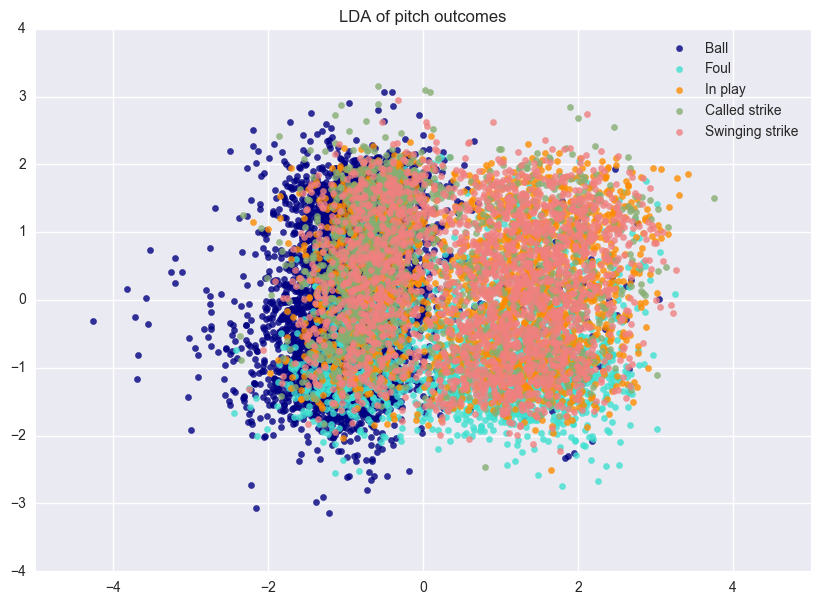

In [34]:
plt.figure(figsize = (10,7))
colors = ['navy', 'turquoise', 'darkorange', 'sage', 'lightcoral']
outcomes = ['Ball', 'Foul', 'In play', 'Called strike', 'Swinging strike']
lw = 2
for color, i, cat in zip(colors, [0,1,2,3,4], outcomes):
    plt.scatter(foultf[ency == i, 0], foultf[ency == i, 1], alpha=.8, color=color,
                label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of pitch outcomes')
plt.show()

Unfortunately, the Linear Discriminant Analysis didn't do a very good job of separating the groups.

Repeat for foul/not-fouled?
Didn't that kind of fail, with LDA reducing it all to just one axis?